## S&P 500 Direction Prediction - Capstone Notebook

### Imports and Settings

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
from sklearn.base import is_classifier
from lightgbm import LGBMClassifier
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score
,classification_report
,confusion_matrix
,roc_auc_score
,balanced_accuracy_score
,roc_curve
,auc
,precision_score
,recall_score
,f1_score) 

import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from src.data_io import load_sp500_data
from src.models import train_and_predict
from src.preprocessing import time_train_test_split
from src.preprocessing import make_time_split_xy
from src.preprocessing import prepare_for_unsupervised
from src.preprocessing import scale_data
from src.evaluation import evaluate_model

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline
sns.set_style("whitegrid")

**This notebook intentionally does not hard-code an end date. It always trains and evaluates using all available data up to the most recent date in the dataset. Therefore metrics and plots may change overtime as new market data comes in**

## Version Notes

This notebook (V2) superseded the original Model Evaluation & Interpretation notebook. It is updated so that it always runs on the latest data which was our original intention, however, for the purpose of reporting, we had to cap version 1 with the last date we were able to work on it. Updates include revised evaluation metrics, cleaned model comparison logic, and some interpretation clarity. This notebook still contains the old results as markdown but you are able to visually see how the graphs and values change over the days.

### Data

##### We download daily S&P 500 price data from 2010 through today using Yahoo Finance. This dataset includes open, high, low, close, adjusted prices, and volume. Data is sorted chronologically to maintain proper time-series structure.

In [8]:
#RS
# start_date = "2010-01-01"
# end_date = datetime.today().strftime("%Y-%m-%d")

data = load_sp500_data(start='2010-01-01', end=datetime.today().strftime("%Y-%m-%d"))
# data = data.reset_index()
# data['Date'] = pd.to_datetime(data['Date'])
# data = data.sort_values("Date").reset_index(drop=True)

# # Fix MultiIndex issues
# if isinstance(data.columns, pd.MultiIndex):
#     data.columns = data.columns.get_level_values(0)

print("Data rows:", len(data))
data.head()

[*********************100%***********************]  1 of 1 completed

Data rows: 4015


Price,Date,Close,High,Low,Open,Volume
0,2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2,2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
3,2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
4,2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


### Create Target Up/Down

##### We defined the target direction as:
- 1 = Next day's close is higher (UP)
- 0 = Next day's close is lower (DOWN)
  
The class distribution shows more UP days, which aligns with long-term market drift.

In [11]:
#RS
data['Direction'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
print(data['Direction'].value_counts(dropna=False))

Direction
1    2194
0    1821
Name: count, dtype: int64


### Feature Engineering

##### We generate common technical indicators:

- 1-day return + lagged returns  
- Rolling volatility  
- Simple moving averages  
- Volume lag  
- RSI  
- MACD + MACD sgnal  

These indicators capture momentum, trend, and volatility.

In [14]:
#RS
data['Return_1'] = data['Close'].pct_change(1)

lags = [1,2,3,5]
for l in lags:
    data[f'Return_lag_{l}'] = data['Return_1'].shift(l)

data['roll_std_5'] = data['Return_1'].rolling(5).std()
data['roll_std_10'] = data['Return_1'].rolling(10).std()

data['SMA_5'] = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_diff_5_10'] = data['SMA_5'] - data['SMA_10']

data['Volume_lag_1'] = data['Volume'].shift(1)

In [15]:
#AA - Extra technical Indicators that may improve model performance

#we can capture return variation over previous 20 days
# 20 days is about a month of market activity

data['rolling_std_20'] = data['Return_1'].rolling(20).std()

#inclusion of Bollinger bands to measure when a price unusally high or low 

band_window = 20
data['SMA_20'] = data['Close'].rolling(band_window).mean()

#create upper and lower boilinger bands

#upper
data['Boilinger_Upper_20'] = data['SMA_20'] + 2 * data['rolling_std_20']

#lower
data['Boilinger_Lower_20'] = data['SMA_20'] - 2 * data['rolling_std_20']

#show the changes to show the short term trend direction
data['Slope_of_SMA_20'] = data['SMA_20'].diff()

#track whether the volume is going more up or down

data['OBV'] =  (np.sign(data['Return_1']) * data['Volume']).cumsum()

#adding price changes over the last 5 days 

data['momentum_5'] = data['Close'] / data['Close'].shift(5) - 1

### Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD)

##### These momentum indicators help detect overbought/oversold conditions and trend strength.

In [18]:
#RS
# RSI
window = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / (avg_loss + 1e-9)
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

### Handling Missing Values

##### Lagged and rolling features introduced missing values in the early rows.
We removed these rows and fixed remaining NaNs.

In [21]:
#RS
max_lag = max(max(lags), 10)

data = data.iloc[max_lag:].reset_index(drop=True)
data = data[~data['Direction'].isna()].reset_index(drop=True)

data['RSI'] = data['RSI'].fillna(method='bfill').fillna(method='ffill')

print(data.isna().sum())

Price
Date                   0
Close                  0
High                   0
Low                    0
Open                   0
Volume                 0
Direction              0
Return_1               0
Return_lag_1           0
Return_lag_2           0
Return_lag_3           0
Return_lag_5           0
roll_std_5             0
roll_std_10            0
SMA_5                  0
SMA_10                 0
SMA_diff_5_10          0
Volume_lag_1           0
rolling_std_20        10
SMA_20                 9
Boilinger_Upper_20    10
Boilinger_Lower_20    10
Slope_of_SMA_20       10
OBV                    0
momentum_5             0
RSI                    0
MACD                   0
MACD_signal            0
dtype: int64


C:\Users\rossg\AppData\Local\Temp\ipykernel_5908\2934768788.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['RSI'] = data['RSI'].fillna(method='bfill').fillna(method='ffill')


### Prepare x and y

##### Raw price columns are removed to avoid leakage.

In [24]:
#RS
drop_cols = ['Date', 'Open', 'High', 'Low', 'Close']
X = data.drop(columns=drop_cols + ['Direction'], errors='ignore')
y = data['Direction']

print("Features:", X.columns.tolist())
print("Shape:", X.shape)

Features: ['Volume', 'Return_1', 'Return_lag_1', 'Return_lag_2', 'Return_lag_3', 'Return_lag_5', 'roll_std_5', 'roll_std_10', 'SMA_5', 'SMA_10', 'SMA_diff_5_10', 'Volume_lag_1', 'rolling_std_20', 'SMA_20', 'Boilinger_Upper_20', 'Boilinger_Lower_20', 'Slope_of_SMA_20', 'OBV', 'momentum_5', 'RSI', 'MACD', 'MACD_signal']
Shape: (4005, 22)


### Train/Test Split (chronological)

##### We use an 80/20 chronological split:

- **Training:** 2010–2022  
- **Testing:** 2022–2025
This simulates real forecasting conditions.

In [27]:
# AA
X_train, X_test, y_train, y_test = make_time_split_xy(
    data,
    split_frac=0.8,
    target_column="Direction",
    drop_cols=["Date", "Open", "High", "Low", "Close"])

X_train_scaled, X_test_scaled = scale_data(X_train, X_test, scale=True)

### Evaluation helper

In [29]:
# AA
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = prepare_for_unsupervised(data, target_col="Direction", drop_cols=drop_cols
)

log_model, log_preds, rf_model, rf_preds, X_train_scaled, X_test_scaled = train_and_predict(X_train, X_test, y_train, y_test)

X_train is a pandas DataFrame.


In [30]:
#AA

print(X_train.columns)
print(X_test.columns)

Index(['Volume', 'Return_1', 'Return_lag_1', 'Return_lag_2', 'Return_lag_3',
       'Return_lag_5', 'roll_std_5', 'roll_std_10', 'SMA_5', 'SMA_10',
       'SMA_diff_5_10', 'Volume_lag_1', 'rolling_std_20', 'SMA_20',
       'Boilinger_Upper_20', 'Boilinger_Lower_20', 'Slope_of_SMA_20', 'OBV',
       'momentum_5', 'RSI', 'MACD', 'MACD_signal'],
      dtype='object', name='Price')
Index(['Volume', 'Return_1', 'Return_lag_1', 'Return_lag_2', 'Return_lag_3',
       'Return_lag_5', 'roll_std_5', 'roll_std_10', 'SMA_5', 'SMA_10',
       'SMA_diff_5_10', 'Volume_lag_1', 'rolling_std_20', 'SMA_20',
       'Boilinger_Upper_20', 'Boilinger_Lower_20', 'Slope_of_SMA_20', 'OBV',
       'momentum_5', 'RSI', 'MACD', 'MACD_signal'],
      dtype='object', name='Price')


### Logistic Regression (Tuned)

##### Logistic Regression Results

Logistic Regression achieved 43.6% accuracy.  
It predicts DOWN days better than UP days but has weak performance.

This is  below the baseline


Logistic Regression Accuracy: 0.4444
Logistic Regression ROC-AUC: 0.4804
              precision    recall  f1-score   support

           0       0.44      0.88      0.59       358
           1       0.49      0.09      0.15       443

    accuracy                           0.44       801
   macro avg       0.46      0.49      0.37       801
weighted avg       0.47      0.44      0.35       801



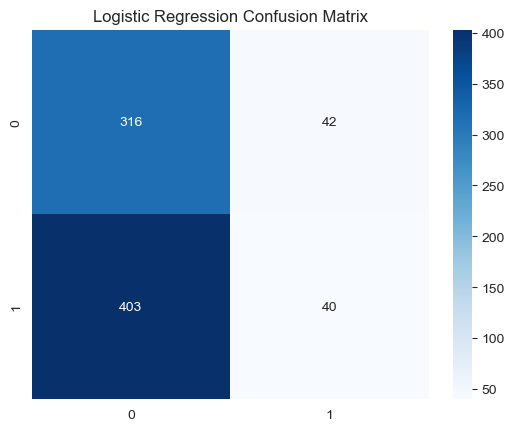

In [33]:
#RS
tscv = TimeSeriesSplit(n_splits=5)

pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE,
                              class_weight = 'balanced'))]) # AA added to give more attention to DOWN days 
#to help predict them better and helps to avoid majority class domination.

param_lr = {'clf__C': [0.01, 0.1, 1, 5]}

rs_lr = RandomizedSearchCV(pipe_lr, param_lr, n_iter=4,
                           cv=tscv, scoring='roc_auc', # AA - changed from accuracy to ROC_AUC to focus on how well 
                           #the model separates UP vs. DOWN days
                           n_jobs=-1, random_state=RANDOM_STATE)

rs_lr.fit(X_train, y_train)
best_lr = rs_lr.best_estimator_

metrics_lr = evaluate_model("Logistic Regression", best_lr, X_test, y_test) #RS/AA updated naming convention

### Random Forest (Tuned)

##### Random Forest Results

Random Forest achieved 44.8% accuracy, lower than the baseline.  
It performs better for DOWN days than UP days but still struggles overall.

It has the highest ROC-AUC of 0.48 but is still close to random guessing.


Random Forest (balanced) Accuracy: 0.4544
Random Forest (balanced) ROC-AUC: 0.4934
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       358
           1       0.51      0.24      0.33       443

    accuracy                           0.45       801
   macro avg       0.47      0.48      0.44       801
weighted avg       0.48      0.45      0.42       801



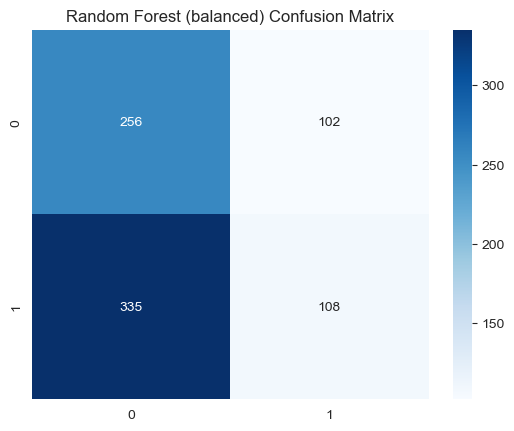

In [36]:
#RS
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE
                                  ,class_weight='balanced_subsample'))]) #AA - Added to re-weigh tree classes to help the minority class

param_rf = {
    'clf__n_estimators': [200, 300, 500],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2,5],
    'clf__min_samples_leaf': [1,4]}

rs_rf = RandomizedSearchCV(pipe_rf, param_rf, n_iter=6,
                           cv=tscv, scoring='roc_auc', #AA -  changed from accuracy to ROC_AUC
                           n_jobs=-1, random_state=RANDOM_STATE)


rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_

metrics_rf = evaluate_model("Random Forest (balanced)", best_rf, X_test, y_test) #RS/AA updated naming convention

### XGBoost (Tuned)

##### XGBoost Results

XGBoost achieved 46.8% accuracy.  
It struggles to separate the overall classes but predicts DOWN days slighly better than UP days.

This is below baseline and has an ROC-AUC of 0.48 which shows its close to random guessing

In [39]:
#AA - need to add class balance for XGBoost

#AA compute DOWN days compared to UP
down_up_ratio = (y_train == 0).sum() / (y_train == 1).sum()

#AA - print out results
print("Class ratio (DOWN / UP):", down_up_ratio)

Class ratio (DOWN / UP): 0.8382099827882961



XGBoost Accuracy: 0.4806
XGBoost ROC-AUC: 0.4972
              precision    recall  f1-score   support

           0       0.45      0.75      0.56       358
           1       0.57      0.26      0.36       443

    accuracy                           0.48       801
   macro avg       0.51      0.51      0.46       801
weighted avg       0.51      0.48      0.45       801



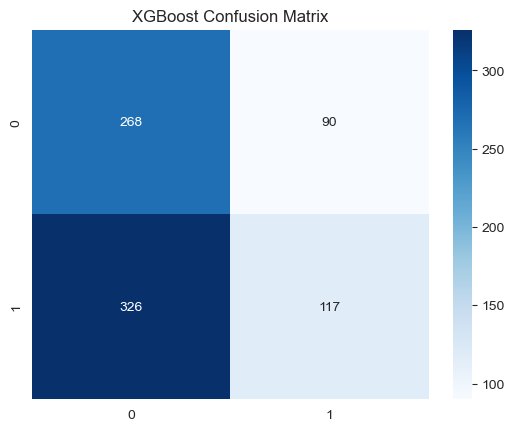

XGBoost metrics: {'accuracy': 0.48064918851435706, 'roc_auc': 0.4972193147281738}


In [40]:
#RS
pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(eval_metric='logloss',
                          random_state=RANDOM_STATE,
                          n_jobs=-1
                         ,scale_pos_weight = down_up_ratio))]) # AA - giving more weight to DOWN by shrinking the weight of UP

param_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [2, 3, 5],
    'clf__learning_rate': [0.01, 0.1]}

rs_xgb = RandomizedSearchCV(pipe_xgb, param_xgb, n_iter=6,
                            cv=tscv, scoring='roc_auc', # AA - changed from accuracy to ROC_AUC
                            n_jobs=-1, random_state=RANDOM_STATE)

rs_xgb.fit(X_train, y_train)
best_xgb = rs_xgb.best_estimator_

# AA - updating with the updated model evaluation which includes accuracy, ROC_AUC, and confusion matrix
metrics_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)
print("XGBoost metrics:", metrics_xgb)

### LightGBM (Tuned)

##### LightGBM Results

LightGBM achieved 47.3% accuracy.  
compared to other models, it has a more balanced performance for UP and DOWN days, but overall its still limited.

It has a ROC-AUC score of 0.48 which is still close to but below random guessing.


LightGBM Accuracy: 0.4744
LightGBM ROC-AUC: 0.5012
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       358
           1       0.54      0.37      0.44       443

    accuracy                           0.47       801
   macro avg       0.49      0.49      0.47       801
weighted avg       0.49      0.47      0.47       801



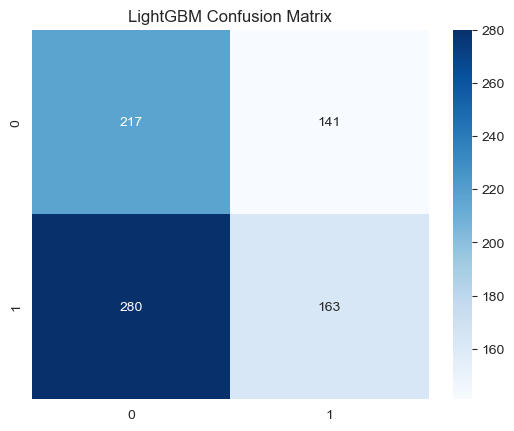

LightGBM metrics: {'accuracy': 0.47440699126092384, 'roc_auc': 0.5011728060330152}


In [43]:
# Trying the addition of LightGBM to see if we get better performance - AA

# Tuned LightGBM - AA

pipe_lgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler()),
    ('clf', LGBMClassifier(objective='binary',
                          random_state=RANDOM_STATE,
                          n_jobs=-1,
                          verbosity=-1)) #added to remove training logs - AA
])

pipe_lgb.set_output(transform="pandas") #added to clear feature name warning - AA

param_lgb = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [-1, 3, 5],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves': [15, 31, 63]
}


rs_lgb = RandomizedSearchCV(pipe_lgb
                            , param_lgb
                            , n_iter=8
                            ,cv=tscv
                            , scoring='roc_auc'
                            ,n_jobs=-1
                            , random_state=RANDOM_STATE)

rs_lgb.fit(X_train, y_train)
best_lgb = rs_lgb.best_estimator_


metrics_lgb = evaluate_model("LightGBM", best_lgb, X_test, y_test)
print("LightGBM metrics:", metrics_lgb)

In [44]:
# AA - Adjusting the threshold to accomodate for ROC-AUC
#sometimes lowering or raising this gives better results

thresholds = [0.40, 0.45, 0.50]

for t in thresholds:
    #get the predicted probs of up
    probs = best_lgb.predict_proba(X_test)[:, 1]
    #convert based on threshold
    preds_t = (probs > t).astype(int)

    accur = accuracy_score(y_test, preds_t)
    precision = precision_score(y_test, preds_t)
    recall = recall_score(y_test, preds_t)
    f1 = f1_score(y_test, preds_t)

    print(f"\nThreshold {t}:")
    print(f"  Accuracy  = {accur:.4f}")
    print(f"  Precision  = {precision:.4f}")
    print(f"  Recall  = {recall:.4f}")
    print(f"  F1 Score  = {f1:.4f}")
    


Threshold 0.4:
  Accuracy  = 0.5218
  Precision  = 0.5636
  Recall  = 0.6005
  F1 Score  = 0.5814

Threshold 0.45:
  Accuracy  = 0.5056
  Precision  = 0.5620
  Recall  = 0.4808
  F1 Score  = 0.5182

Threshold 0.5:
  Accuracy  = 0.4744
  Precision  = 0.5362
  Recall  = 0.3679
  F1 Score  = 0.4364


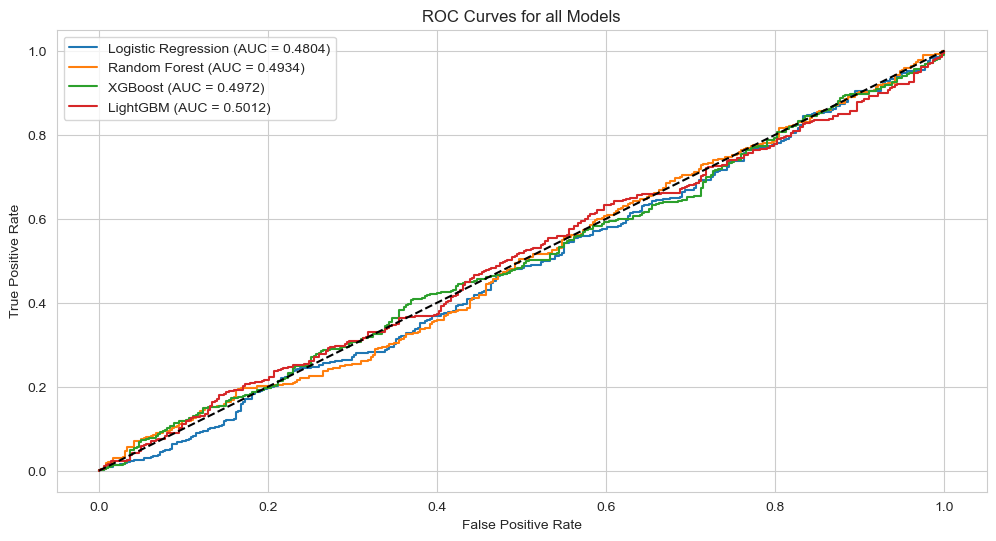

In [45]:
# AA - Adding ROC curves for all three models

def roc_curve_plt(model, X_test, y_test, label):
    #we first need the probability of UP for tomorrow

    probs = model.predict_proba(X_test)[:, 1]

    #next we need the false positives and true positives
    fpr, tpr, _ = roc_curve(y_test, probs)

    #we compute AUC score based on the curve
    roc_auc = auc(fpr, tpr)

    #now we can do the actual plot
    plt.plot(fpr, tpr, label = f"{label} (AUC = {roc_auc:.4f})")

plt.figure(figsize=(12,6))


# AA - we can plot ROC curve for each model
roc_curve_plt(best_lr, X_test, y_test, "Logistic Regression")
roc_curve_plt(best_rf, X_test, y_test, "Random Forest")
roc_curve_plt(best_xgb, X_test, y_test, "XGBoost")
roc_curve_plt(best_lgb, X_test, y_test, "LightGBM")

# AA - we can add a diagonal line which indicates random guessing
plt.plot([0,1], [0,1], 'k--')

plt.title("ROC Curves for all Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Baseline Accuracy

##### Baseline Accuracy

The baseline (always predict UP) is 55.19%.  
Our best model (XGBoost at 55%) does not beat the baseline.

This is important and aligns with market efficiency theory.

In [48]:
#RS
baseline = y_test.value_counts(normalize=True).max()
print("Baseline accuracy:", baseline)

Baseline accuracy: 0.5530586766541823


## Feature Importance

#####  Feature Importance Insights

Most models rely heavily on:

- Lagged returns  
- Volatility (rolling std)  
- MACD / MACD signal  
- SMA differences  

These features reflect short-term momentum and market noise.

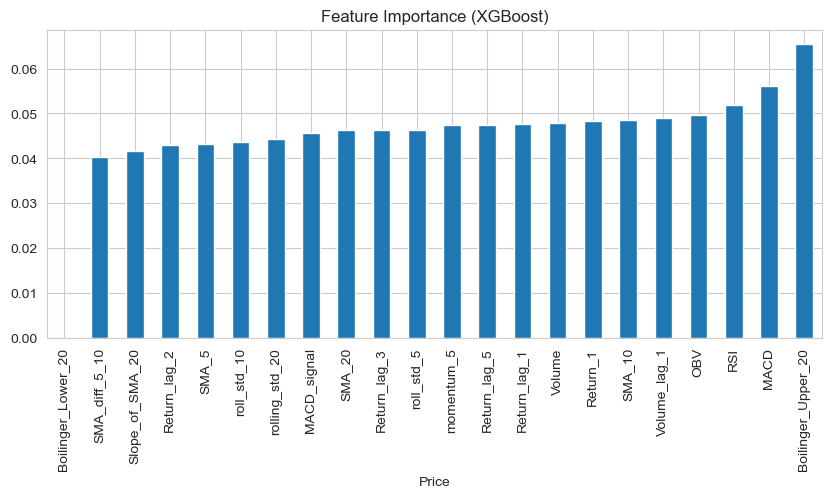

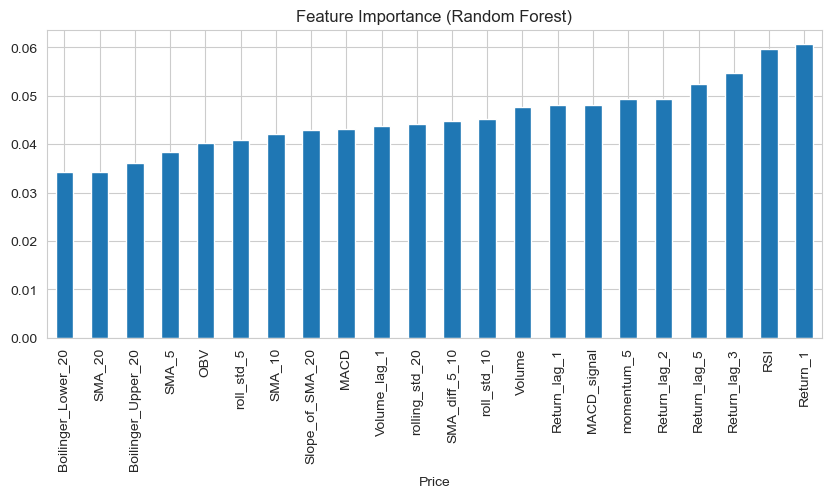

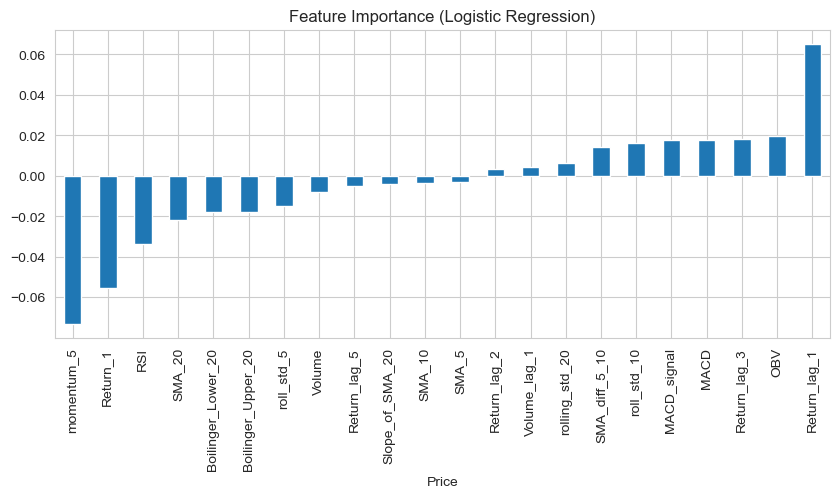

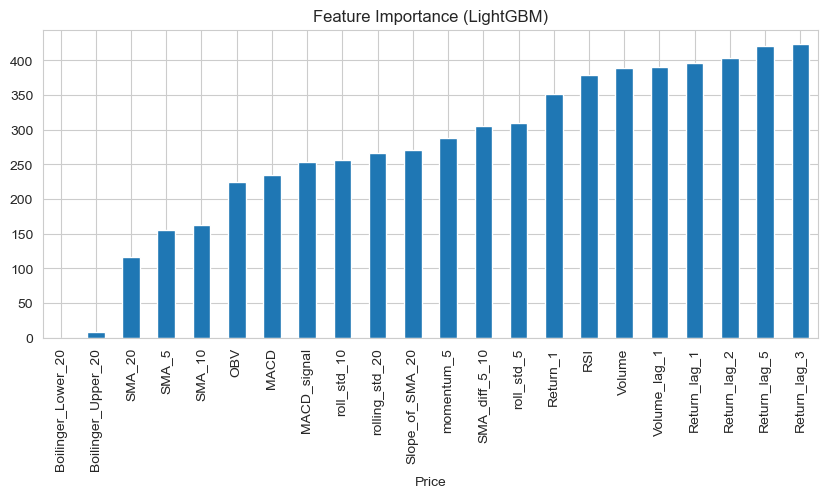

In [51]:
#RS
# XGBoost
try:
    importances = pd.Series(best_xgb.named_steps['clf'].feature_importances_,
                            index=X.columns)
    importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (XGBoost)")
    plt.show()
except:
    pass

# Random Forest
try:
    rf_importances = pd.Series(best_rf.named_steps['clf'].feature_importances_,
                               index=X.columns)
    rf_importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (Random Forest)")
    plt.show()
except:
    pass

# Logistic Regression
try:
    coefs = pd.Series(best_lr.named_steps['clf'].coef_[0], index=X.columns)
    coefs.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (Logistic Regression)")
    plt.show()
except:
    pass

# LightGBM - AA

try:
    lgb_clf = best_lgb.named_steps['clf']
    feature_names = X_train.columns
    lgb_importances = pd.Series(lgb_clf.feature_importances_,index=X.columns)
    lgb_importances.sort_values().plot(kind='bar', figsize=(10,4))
    plt.title("Feature Importance (LightGBM)")
    plt.show() 
except Exception as e:
    print("Could not plot Feature importance for LightGBM:", e)

## Rolling 50-Day Accuracy

##### Rolling Accuracy Interpretation
Rolling 50-day accuracy fluctuates near the baseline. Models perform well during trending markets but poorly during volatile or sideways periods.

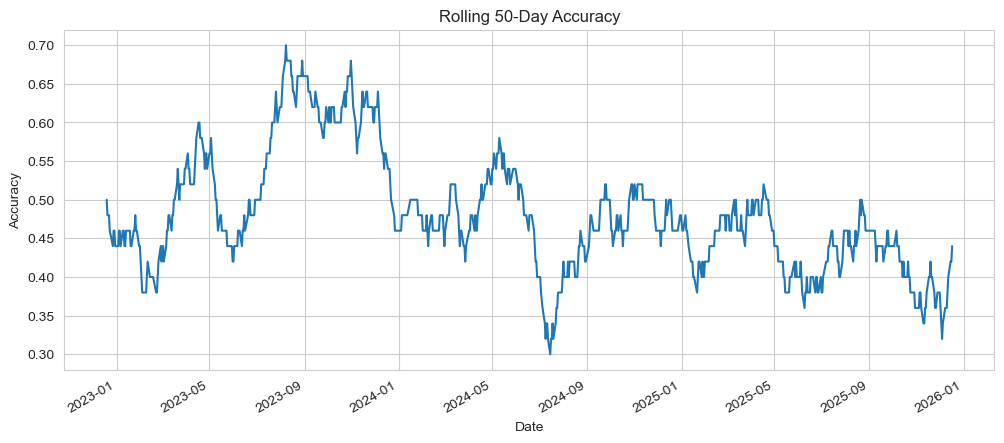

In [54]:
# Added to use .py files - AA
X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test = prepare_for_unsupervised(data, target_col="Direction")

#RS
final_model = best_xgb

# Align features to model training
model_features = final_model.feature_names_in_
X_test_aligned = X_test[model_features]

preds = final_model.predict(X_test_aligned)

results = pd.DataFrame({
    "Date": data['Date'].iloc[len(X_train):],
    "Actual": y_test.values,
    "Pred": preds})

results['Correct'] = results['Actual'] == results['Pred']

results.set_index("Date")['Correct'].rolling(50).mean().plot(figsize=(12,5))
plt.title("Rolling 50-Day Accuracy")
plt.ylabel("Accuracy")
plt.show()

### Pick and save best model

In [56]:
#RS

#AA - adding to this by model selection using ROC-AUC
# candidates = {
#     "logreg": (best_lr, acc_lr),
#     "rf": (best_rf, acc_rf),
#     "xgb": (best_xgb, acc_xgb)}

#AA
candidates = {
    "Logistic Regression": metrics_lr,
    "Random Forest": metrics_rf,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgb}

best_name = max(candidates, key=lambda name: candidates[name]["roc_auc"]) #AA
best_model_metrics = candidates[best_name] #AA

print(f"Best model(based on ROC-AUC): {best_name}") #RS/AA updated to make sure its know to be based off ROC-AUC
print(f"Metrics: {best_model_metrics}") #AA

#AA - Adding to save the actual model itself

if best_name == "Logistic Regression":
    final_model = best_lr
elif best_name == "Random Forest":
    final_model = best_rf
elif best_name == "LightGBM":
    final_model = best_lgb
else:
    final_model = best_xgb
    
joblib.dump(final_model, "sp500_model_capstoneV2.joblib")

Best model(based on ROC-AUC): LightGBM
Metrics: {'accuracy': 0.47440699126092384, 'roc_auc': 0.5011728060330152}


['sp500_model_capstoneV2.joblib']

To choose the best model, we compared ROC-AUC scores of all four of our models:

- Logistic Regression  
- Random Forest  
- XGBoost  
- LightGBM

We choose ROC-AUC because its better for data with class imbalance. Accuracy can be especially be misleading when there is class imbalance.

The model with the highest ROC-AUC score is then selected as our final model. This model is then used for the daily predictions and threshold tuning.

In [58]:
# AA - Creating a quick data frame of all model metrics

df_metrics = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [metrics_lr["accuracy"]
                 ,metrics_rf["accuracy"]
                 ,metrics_xgb["accuracy"]
                 ,metrics_lgb["accuracy"]],
    "ROC_AUC": [metrics_lr["roc_auc"]
                ,metrics_rf["roc_auc"]
                ,metrics_xgb["roc_auc"]
                ,metrics_lgb["roc_auc"]]
})

print("Overall Model performace summary for the test set:")
display(df_metrics)

Overall Model performace summary for the test set:


,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.444444,0.480434
1,Random Forest,0.454432,0.493442
2,XGBoost,0.480649,0.497219
3,LightGBM,0.474407,0.501173


In [59]:
# AA - incorporate the best threshold

threshold_final = 0.40

def final_pred(model, X, threshold = threshold_final):
    probs = model.predict_proba(X)[:, 1]
    return (probs > threshold).astype(int)

### DAILY PREDICTION PIPELINE

##### Daily Prediction Interpretation

The random forest model, chosen by ROC-AUC predicts the next day’s direction and probability for UP.  

- This model used the latest technical features and give the probability of the next day being UP.
- Instead of using the default threshold of 0.50, we chose a 0.40 threshold because it gave better accuracy and balance for our tests
- This threshold basically says if the probability of UP is above 40% we predict UP otherwise the prediction is DOWN.

In [62]:
#RS
model = final_model #AA - UPDATED

# Align feature order
model_features = model.feature_names_in_
X_latest = X[model_features].iloc[[-1]]

pred = final_pred(model, X_latest)[0]
prob = model.predict_proba(X_latest)[0][1]

# Convert to percent and round to 2 decimals
prob_percent = round(prob * 100, 2)

print("Prediction for next trading day after:", data['Date'].iloc[-1])
print("Predicted direction:", "UP" if pred == 1 else "DOWN")
print(f"Probability of UP: {prob_percent:.2f}%")

Prediction for next trading day after: 2025-12-17 00:00:00
Predicted direction: DOWN
Probability of UP: 36.04%


### Final Summary

##### This project explored predicting daily S&P 500 direction using traditional technical indicators.

##### Key Findings

No model beat the baseline accuracy (predict UP every day).    

**Comparison of baseline to models**

- We have a simple baseline rule of always predicting UP which gets an accuracy of around 55% on the test set.
- All tuned models do not beat the baseline and had around 43-47% accuracy

**ROC-AUC**

- The ROC-AUC for all models reched around 0.47-0.48 on the test set.
- Rodom Forest was our best model at about 0.48, however this isn't better than random guessing would be at 0.50.

**Improvement Attempts**

- Addition of more features such as Volatility, Bollinger Bands, Momentum, OBV.
- Handling of class imbalance and a tuned threshold

While these improvements give us a more robust evaluation but didn't create a strong predictive model.

**What this means/Bigger Picture**

- Down days are still very hard to predict over up days.
- the models stuggled to reliably separate a down versus up days, supporting the idea that short-term price direction is hard to forecast.



##### Interpretation

The results show that daily market movement is hard to predict, even with additional features and machine learning models. None of them were
able to beat baseline and this strongly suggests that daily changes are mostly noise, making the next day predictions difficult.

##### Possible Next Steps

- Include macroeconomic indicators (VIX, yield curve, unemployment).  
- Explore longer-horizon predictions (weekly/monthly).  
- Add regime detection (bull/bear markets).  
- Try hybrid models or ensemble approaches.

The notebook provides a realistic, interpretable analysis consistent with both data science and financial theory.

**Review Notes:** In this notebook there is better Modularization (use of .py files and helper functions), however, There is still some duplicated logic - AA

**Review Notes:** This version did a great job with threshold tuning, and daily prediction logic, which made the workflow clearer and more practical. For next steps, we could try streamlining some of the repeated evaluation steps and exploring how adjusting thresholds or combining models might improve real-time predictions - RS

This notebook was run end-to-end on my local machine without errors - AA

In [ ]:
This notebook was run end-to-end on my local machine without errors - RS